<h2>This notebook contains example code for the retraining experiments</h2>
    
- In the main text, we trial over 10 random training seeds (one for each base model)
- This code currently uses 1 training seed, so graphs can be generated relatively quickly
- Dataset can be varied between dname='heloc' and dname='adult'

<h2> For code that generates plots</h2>

- Scroll to the end of the notebook to view this code
- Data for the plots is generated by the code up until then
- Cells should be executed sequentially to avoid errors

In [ ]:
from parser_utils import create_parser, process_args
import datasets
import numpy as np
from xgboost import XGBClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap, lime
from joblib import dump, load
import os

# Parser

In [2]:
dname = 'heloc'  # or 'adult'

In [3]:
parser = create_parser()
args = parser.parse_args(args=[dname, 'data/' + dname, '--output_dir', f'models/{dname}_retraining_xgb'])
args = process_args(args)
args

Namespace(dataset='heloc', file_base='data/heloc', dataset_shift=False, adversarial=False, output_dir='models/heloc_retraining_xgb', label_col='label', linear=False, lr=0.2, lr_decay=None, epochs=20, batch_size=128, activation='relu', nodes_per_layer=50, num_layers=5, optimizer=None, loss=CrossEntropyLoss(), fixed_seed=False, target_indices=[], target_vals=[], indices_to_change=[], new_vals=[], threshold=0.0, strategy='random', epsilon=0.5, dropout=0.0)

In [4]:
output_dir = args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'models/heloc_retraining_xgb'

# Data and Parameters

In [73]:
thresh = 0
n_test = 100
perturb_params = datasets.PerturbParams(args.strategy, thresh,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
scaler, scaler_labels = None, None
train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                 scaler_labels, 0, perturb_params, noisy_test=False)
num_feat, num_classes = train.num_features(), train.num_classes()

# Train/test data
X, y = train.data, train.labels.to_numpy()[:, 0]
X_test = test.data#[:n_test]
y_test = test.labels.to_numpy()[:,0]#[:n_test, 0]

In [74]:
n_te, d = X_test.data.shape
n_te, d

(1975, 23)

# Train Base Models

In [10]:
# Essentially weight decay
reg_lambdas = [1, 10, 100, 1000]
reg_lambdas

[1, 10, 100, 1000]

In [13]:
test_accs = np.zeros(len(reg_lambdas))
train_accs = np.zeros(len(reg_lambdas))
depth = 32
n_estimators = 5
lr = 1
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    # base = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=10)
    # base = base.fit(X, y)
    base = XGBClassifier(n_estimators=n_estimators, max_depth=depth, learning_rate=lr,
                         reg_lambda=reg_lambda, objective='binary:logistic').fit(X, y)

    # Predict
    pred_te = base.predict(X_test)
    pred_tr = base.predict(X)

    # Accuracy
    test_accs[i] = (pred_te == y_test).mean()
    train_accs[i] = (pred_tr == y).mean()

    dump(base, output_dir + f'/base_depth{depth}_lambda{reg_lambda}.joblib')

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


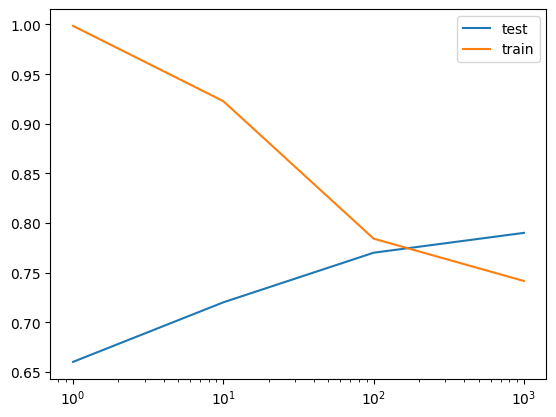

In [14]:
plt.plot(reg_lambdas, test_accs, label='test')
plt.plot(reg_lambdas, train_accs, label='train')
plt.xscale('log')
plt.legend()
plt.show()

# Retrain Models under Dataset Shift - Synthetic Noise

In [68]:
# Standard deviations for synthetic noise
noise_seeds = range(10)
thresholds = np.logspace(-3, -0.3, 10)
threshold = 0.1
threshold

0.1

In [67]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            perturb_params = datasets.PerturbParams(args.strategy, threshold,
                                                    args.target_indices, args.target_vals,
                                                    args.indices_to_change, args.new_vals)
            scaler, scaler_labels = None, None
            train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                             scaler_labels, noise_seed, perturb_params, noisy_test=False)
            # model = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=10)
            # model = model.fit(train.data, train.labels.to_numpy()[:, 0])
            model = XGBClassifier(n_estimators=n_estimators, max_depth=depth, learning_rate=lr, reg_lambda=reg_lambda,
                                  objective='binary:logistic').fit(train.data, train.labels.to_numpy()[:, 0])
            models.append(model)
    dump(models, output_dir+f'/models_depth{depth}_lambda{reg_lambda}.joblib')

  0%|          | 0/4 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [69]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    models = []
    for idx, noise_seed in enumerate(noise_seeds):
        perturb_params = datasets.PerturbParams(args.strategy, threshold,
                                                args.target_indices, args.target_vals,
                                                args.indices_to_change, args.new_vals)
        scaler, scaler_labels = None, None
        train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                            scaler_labels, noise_seed, perturb_params, noisy_test=False)
        # model = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=10)
        # model = model.fit(train.data, train.labels.to_numpy()[:, 0])
        model = XGBClassifier(n_estimators=n_estimators, max_depth=depth, learning_rate=lr, reg_lambda=reg_lambda,
                                objective='binary:logistic').fit(train.data, train.labels.to_numpy()[:, 0])
        models.append(model)
    dump(models, output_dir+f'/models_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


# Compute Explanations

In [70]:
# Compute LIME explanations for one base model
def explain_lime(model, X_test):
    explainer = lime.lime_tabular.LimeTabularExplainer(X, class_names=['0', '1'],
                                                       discretize_continuous=False)
    lime_exps = np.zeros((X_test.shape[0], X_test.shape[1]))
    for idx in range(X_test.shape[0]):
        exp = explainer.explain_instance(X_test[idx], model.predict_proba,
                                        num_features=num_feat, num_samples=5000)
        feature_idxs = [int(i[0]) for i in exp.as_list()]
        lime_values = [i[1] for i in exp.as_list()]
        lime_exps[idx, feature_idxs] = np.array(lime_values)
    return np.array(lime_exps)

### SHAP Explanations

In [18]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    base = load(output_dir + f'/base_depth{depth}_lambda{reg_lambda}.joblib')
    
    # Compute shap
    explainer = shap.Explainer(base)
    shap_test = explainer(X_test).values#[:, :, 1]

    # Save gradients/explanations
    dump(shap_test, output_dir+f'/base_shap_depth{depth}_lambda{reg_lambda}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}.joblib')
    
    shap_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute shap
            explainer = shap.Explainer(model)
            shap_test = explainer(X_test, check_additivity=False).values#"[:, :, 1]
            shap_test_models.append(shap_test)
    dump(shap_test_models, output_dir+f'/models_shap_depth{depth}_lambda{reg_lambda}.joblib')

100%|██████████| 4/4 [02:06<00:00, 31.56s/it]


In [71]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    base = load(output_dir + f'/base_depth{depth}_lambda{reg_lambda}.joblib')
    
    # Compute shap
    explainer = shap.Explainer(base)
    shap_test = explainer(X_test).values#[:, :, 1]

    # Save gradients/explanations
    dump(shap_test, output_dir+f'/base_shap_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')
    
    shap_test_models = []
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        # Compute shap
        explainer = shap.Explainer(model)
        shap_test = explainer(X_test, check_additivity=False).values#"[:, :, 1]
        shap_test_models.append(shap_test)
    dump(shap_test_models, output_dir+f'/models_shap_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


### LIME Explanations

In [64]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    base = load(output_dir + f'/base_depth{depth}_lambda{reg_lambda}.joblib')
    
    # Compute lime
    lime_test = explain_lime(base, X_test[:100])

    # Save explanations
    dump(lime_test, output_dir+f'/base_lime_depth{depth}_lambda{reg_lambda}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}.joblib')
    
    lime_test_models = []
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            # Compute lime
            lime_test = explain_lime(model, X_test[:100])
            lime_test_models.append(lime_test)
    dump(lime_test_models, output_dir+f'/models_lime_depth{depth}_lambda{reg_lambda}.joblib')

100%|██████████| 4/4 [18:15<00:00, 273.88s/it]


In [72]:
for i, reg_lambda in enumerate(tqdm(reg_lambdas)):
    base = load(output_dir + f'/base_depth{depth}_lambda{reg_lambda}.joblib')
    
    # Compute lime
    lime_test = explain_lime(base, X_test)

    # Save explanations
    dump(lime_test, output_dir+f'/base_lime_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

    # Load models
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')
    
    lime_test_models = []
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        # Compute lime
        lime_test = explain_lime(model, X_test)
        lime_test_models.append(lime_test)
    dump(lime_test_models, output_dir+f'/models_lime_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

100%|██████████| 4/4 [01:23<00:00, 20.77s/it]


# Compute Top-K Explanation Stability

In [26]:
from metrics import get_top_k, top_k_sa, top_k_cdc, top_k_ssa

In [27]:
exps = ['shap', 'lime']
mets = [top_k_sa, top_k_cdc, top_k_ssa] #
met_names = ['sa', 'cdc', 'ssa']
ks = [5]  # values of k in top-k

In [36]:
depth = 32
for exp in exps:
    print(f'Computing {exp.title()} Metrics...')
    for m, met in enumerate(tqdm(mets)):
        for k in ks:
            exp_met_ks = np.zeros((len(reg_lambdas), len(noise_seeds)))
            for i, reg_lambda in enumerate(reg_lambdas):
                # g1 represents base model gradients
                g1 = load(output_dir+f'/base_{exp}_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')
                s1 = np.sign(g1)
                tk1 = get_top_k(k, g1)

                # Load explanations from models
                exp_test_models = load(output_dir+f'/models_{exp}_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')

                for idx, noise_seed in enumerate(noise_seeds):
                    # g2 represents shifted model explanations
                    g2 = exp_test_models[idx]
                    s2 = np.sign(g2)
                    tk2 = get_top_k(k, g2)
                    exp_met_ks[i,idx] = met(k, tk1, tk2, s1, s2)

            # save exp-met-k combo
            dump(exp_met_ks, output_dir+f'/{exp}_top_{k}_{met_names[m]}_thresh{threshold}.npy')

Computing Shap Metrics...


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Computing Lime Metrics...


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


# Quick Results

In [62]:
shap_sa = load(output_dir+f'/shap_top_5_sa_thresh{threshold}.npy')
q = np.quantile(shap_sa, [0.25, 0.5, 0.75], axis=1)
q[0], (q[2]+q[0])/2, q[2], (q[2]-q[0])/2

(array([0.452 , 0.506 , 0.644 , 0.7695]),
 array([0.466  , 0.52125, 0.66025, 0.79675]),
 array([0.48  , 0.5365, 0.6765, 0.824 ]),
 array([0.014  , 0.01525, 0.01625, 0.02725]))

In [63]:
lime_sa = load(output_dir+f'/lime_top_5_sa_thresh{threshold}.npy')
q = np.quantile(lime_sa, [0.25, 0.5, 0.75], axis=1)
q[0], (q[2]+q[0])/2, q[2], (q[2]-q[0])/2

(array([0.6675, 0.6595, 0.6315, 0.6335]),
 array([0.728  , 0.727  , 0.70625, 0.71525]),
 array([0.7885, 0.7945, 0.781 , 0.797 ]),
 array([0.0605 , 0.0675 , 0.07475, 0.08175]))

In [75]:
# Load models
model_accs = []
for i, reg_lambda in enumerate(reg_lambdas):
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}_thresh{threshold}.joblib')
    model_acc = np.zeros(len(noise_seeds))
    for idx, noise_seed in enumerate(noise_seeds):
        model = models[idx]
        model_acc[idx] = (model.predict(X_test)==y_test).mean()
    model_accs.append(model_acc)
q = np.quantile(np.array(model_accs), [0.25, 0.5, 0.75], axis=1)
100*q[0], 100*(q[2]-q[0])/2

(array([68.10126582, 69.36708861, 71.81012658, 72.72151899]),
 array([0.78481013, 0.56962025, 0.47468354, 0.24050633]))

# Plot Explanation Stability

In [32]:
met_names = ['sa', 'cdc', 'ssa']
met_names_full = ['Sign-Agreement (SA)',
                  'Consistent-Direction-of-Contribution (CDC)',
                  'Signed-Set-Agreement (SSA)']
k=5

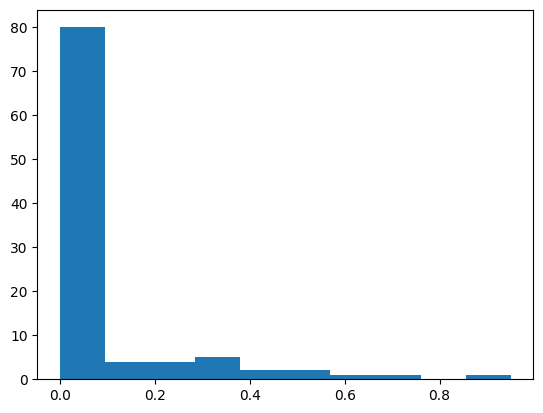

In [46]:
plt.hist(exp_met_ks[3])
plt.show()

### All Similarity Metrics

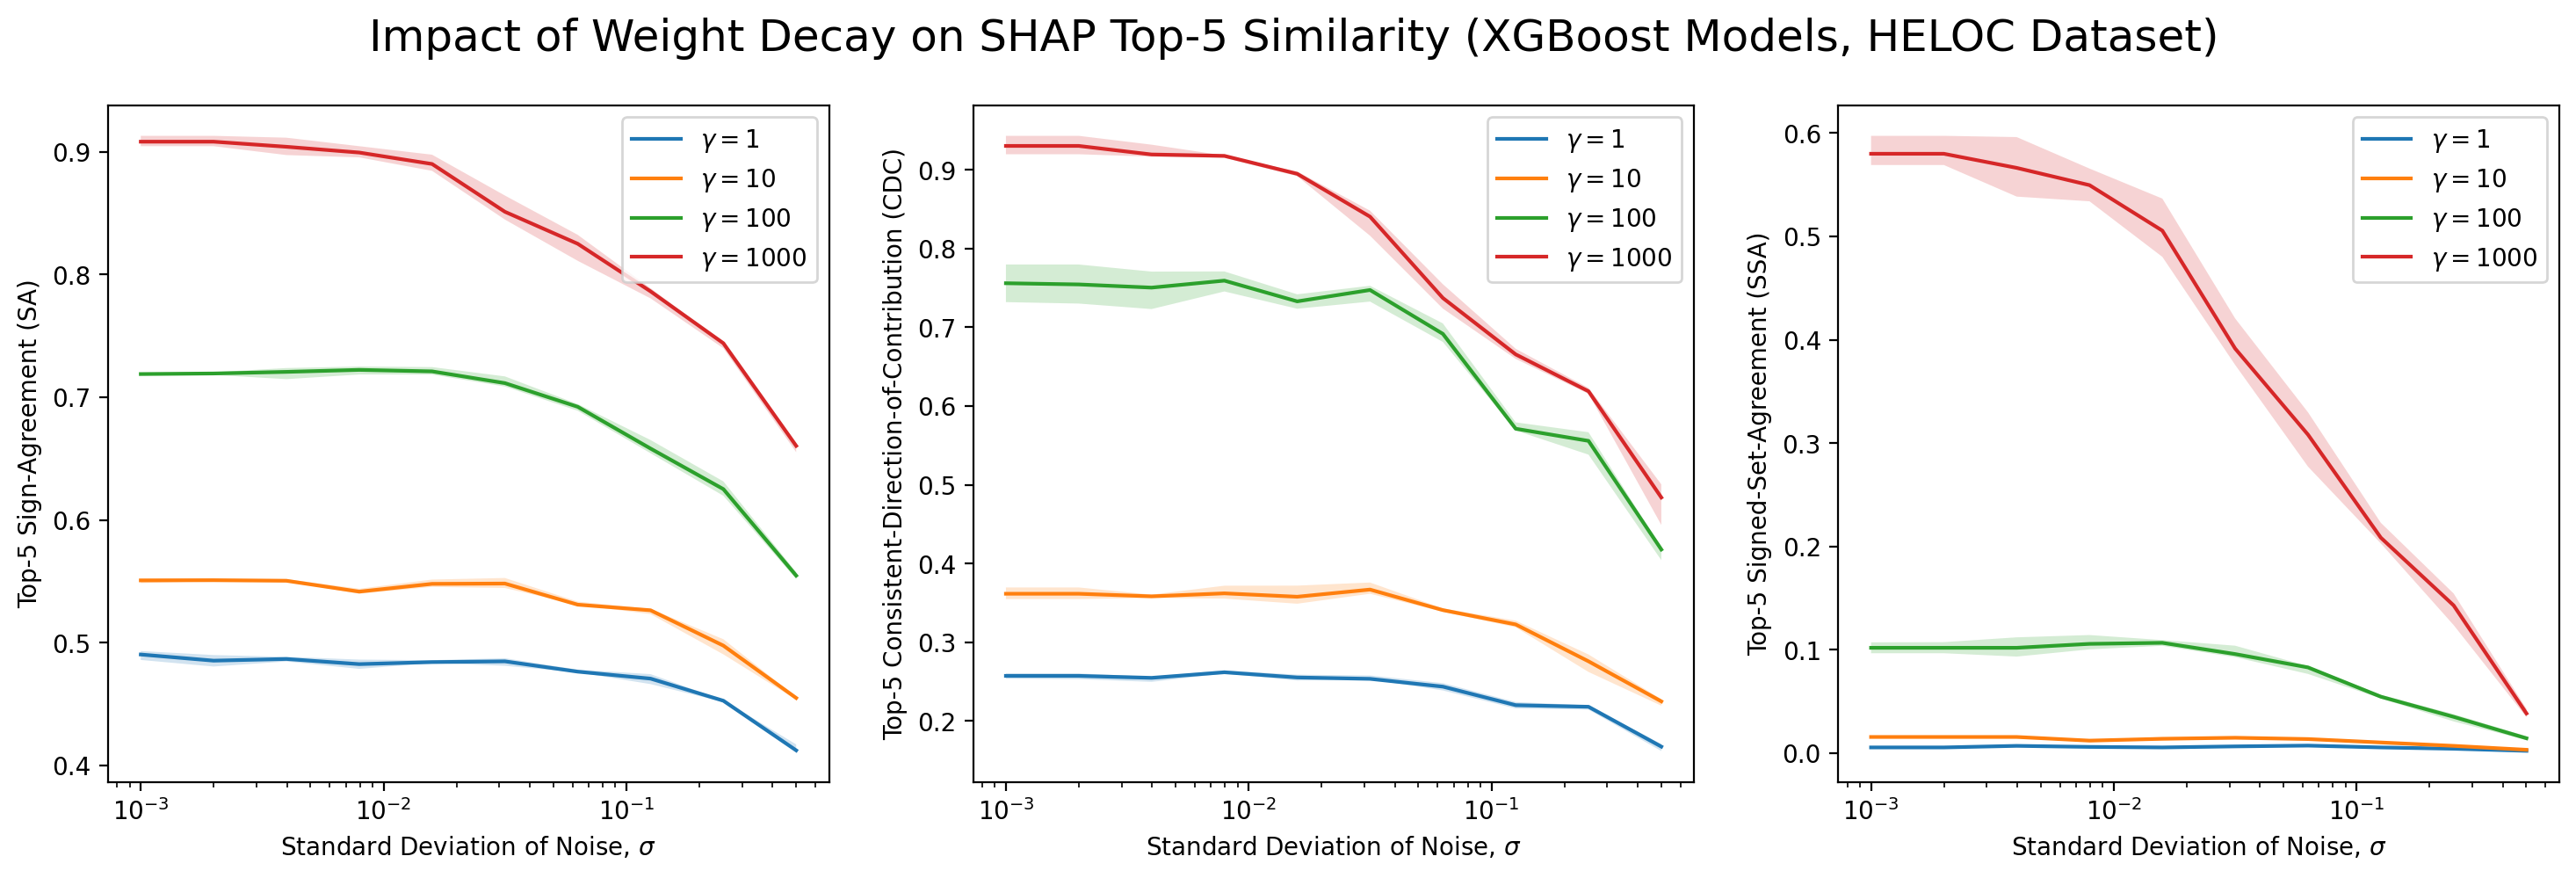

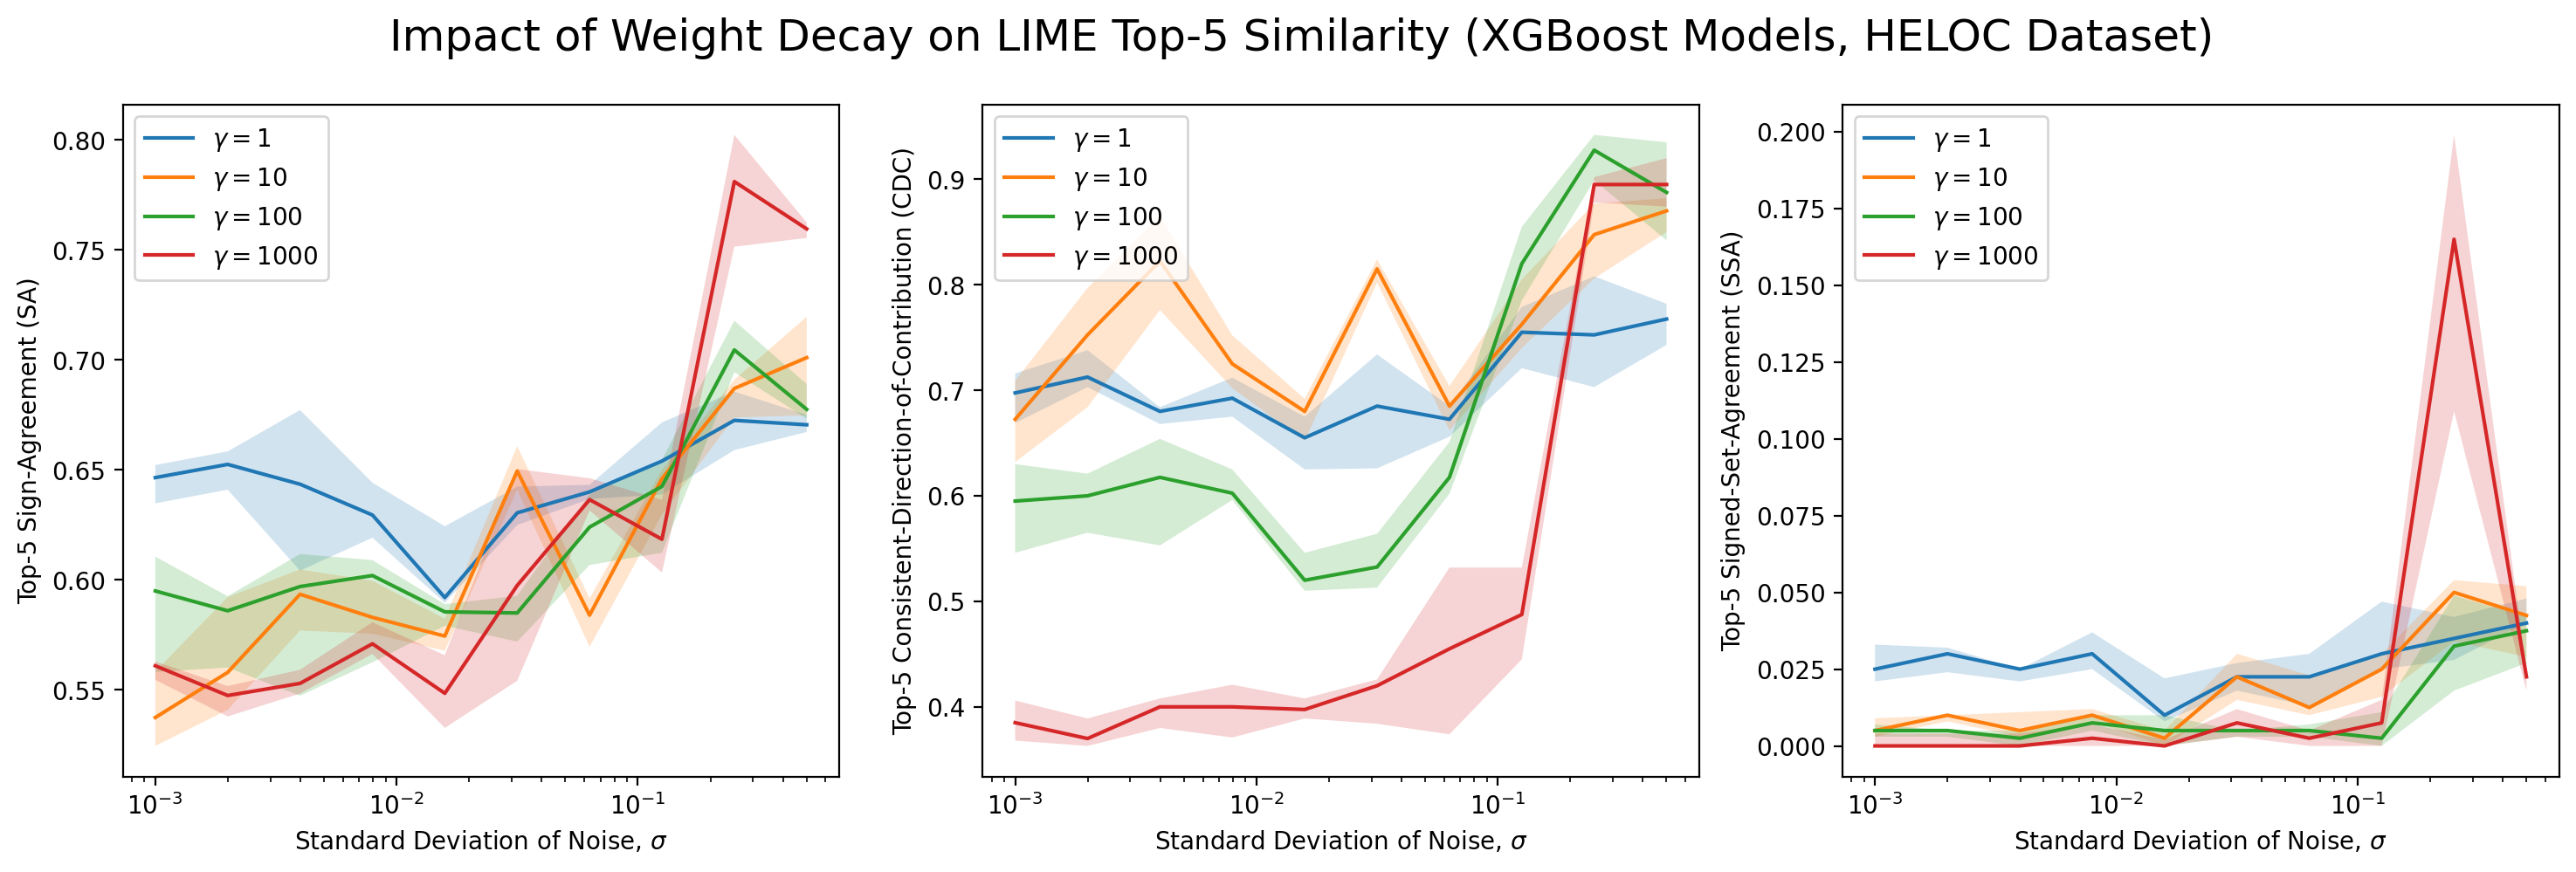

In [69]:
for exp in exps:
    fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=200)
    for i, met in enumerate(met_names):
        topk = load(output_dir+f'/{exp}_top_{k}_{met}.npy')
        ax[i].set_ylabel(f'Top-{k} {met_names_full[i]}')
        ax[i].set_xlabel('Standard Deviation of Noise, $\sigma$')
        for j, reg_lambda in enumerate(reg_lambdas):
            q = np.quantile(topk[j], [0.4, 0.5, 0.6], axis=1)
            ax[i].plot(thresholds, q[1], label=f'$\gamma=${reg_lambda}')
            ax[i].fill_between(thresholds, q[0], q[2], alpha=0.2)
        ax[i].set_xscale('log')
        ax[i].legend()
    plt.suptitle(f'Impact of Weight Decay on {exp.upper()} Top-5 Similarity (XGBoost Models, HELOC Dataset)', fontsize=18)
    plt.show()

### Single Similarity Metric

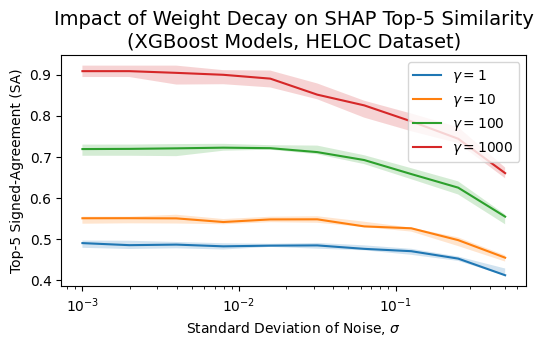

In [133]:
topk = load(output_dir+f'/shap_top_{k}_sa_lambda.npy')
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Weight Decay on SHAP Top-5 Similarity\n(XGBoost Models, HELOC Dataset)', fontsize=14)
plt.ylabel('Top-5 Signed-Agreement (SA)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, reg_lambda in enumerate(reg_lambdas):
    q = np.quantile(topk[i], [0.25, 0.5, 0.75], axis=1)
    plt.plot(thresholds, q[1], label=f'$\gamma=${reg_lambda}')
    plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend()
plt.show()

In [139]:
# Load models
model_accs = []
for i, reg_lambda in enumerate(reg_lambdas):
    models = load(output_dir+f'/models_depth{depth}_lambda{reg_lambda}.joblib')
    model_acc = np.zeros((len(thresholds), len(noise_seeds)))
    for j, threshold in enumerate(thresholds):
        for idx, noise_seed in enumerate(noise_seeds):
            model = models[j*len(noise_seeds) + idx]
            model_acc[j,idx] = (model.predict(X_test)==y_test).mean()
    model_accs.append(model_acc)

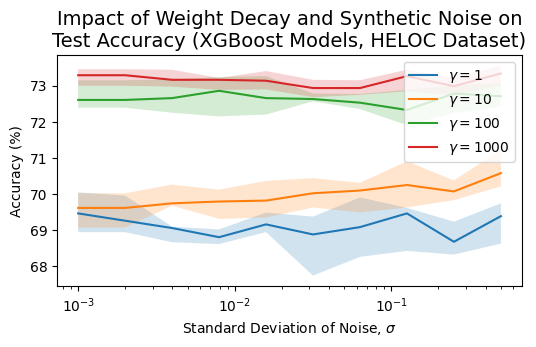

In [144]:
plt.figure(figsize=(6,3), dpi=100)
plt.title('Impact of Weight Decay and Synthetic Noise on\nTest Accuracy (XGBoost Models, HELOC Dataset)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xlabel('Standard Deviation of Noise, $\sigma$')
for i, reg_lambda in enumerate(reg_lambdas):
    q = np.quantile(model_accs[i], [0.25, 0.5, 0.75], axis=1)*100
    plt.plot(thresholds, q[1], label=f'$\gamma=${reg_lambda}')
    plt.fill_between(thresholds, q[0], q[2], alpha=0.2)
plt.xscale('log')
plt.legend(loc='upper right')
plt.show()